# Dog breeds classification

In this notebook I tried to classify dog breed using the Stanford dog dataset with two differents methods.
The first one use a classical approach using bags of features with visual words and applying a classification algorithm like SVM.
The second one is the classification using transfer learning with a CNN (Convolution Neural Network).

First I import all the libraries :

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from scipy import stats
import tarfile 
import scipy.io
import cv2
import os

%matplotlib inline 

## Preprocessing images

### Example

Before starting with all the dataset, let's have an idea of all changes I apply to an image :

In [2]:
# First image in the dataset
img = cv2.imread('../data/Images/n02086240-Shih-Tzu/n02086240_1011.jpg')

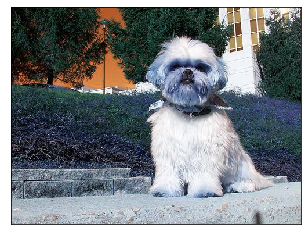

In [3]:
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

#### 1. Centering the image on the dog 

To improve my classification algorithms I will first recenter the image on the dog (the Standard dog dataset provide us the exact position of the dog) to drop all features which can be generate by the surroundings.

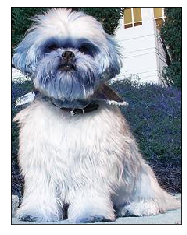

In [4]:
img = img[51:331, 232:451]
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

#### 2. Resizing image

All images are not necessarly the same size which can be really problematic in further treatments. Furthermore, the CNN I will later use using transfer learning need a fix image size of .  

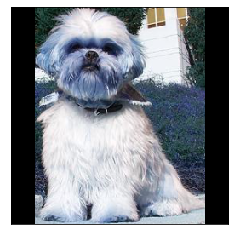

In [5]:
# Cropping and padding the image to a standard size of 256
desired_size = 256

old_size = img.shape[:2] 

ratio = float(desired_size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])

img = cv2.resize(img, (new_size[1], new_size[0]))

delta_w = desired_size - new_size[1]
delta_h = desired_size - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=color)

plt.imshow(img)

plt.xticks([]), plt.yticks([])
plt.show()

#### 3. Histogram equalization

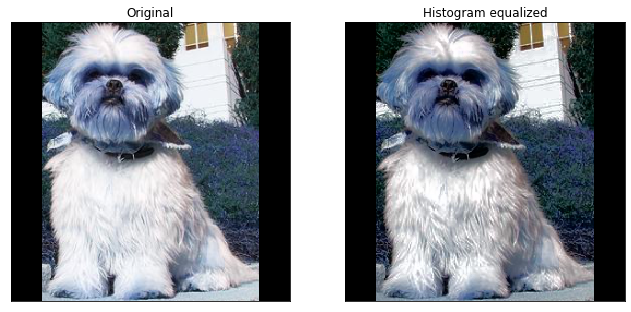

In [18]:
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

# equalize the histogram of the Y channel
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

# convert the YUV image back to RGB format
img_equal = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

plt.figure(figsize=(11,6))
plt.subplot(121), plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_equal),plt.title('Histogram equalized')
plt.xticks([]), plt.yticks([])
plt.show()

#### 4. Gaussian filter to reduce the noise and improve edge detection  

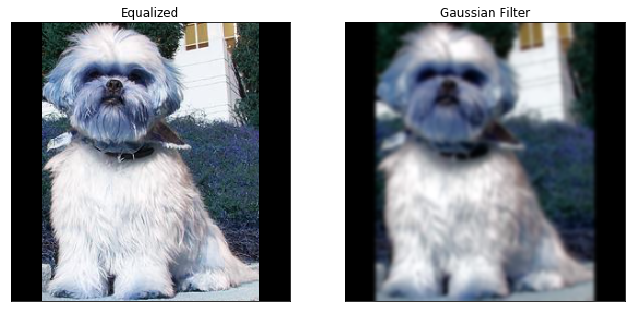

In [7]:
figure_size = 9

img_gaussian = cv2.GaussianBlur(img_equal, (figure_size, figure_size),0)

plt.figure(figsize=(11,6))
plt.subplot(121), plt.imshow(img),plt.title('Equalized')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_gaussian),plt.title('Gaussian Filter')
plt.xticks([]), plt.yticks([])
plt.show()

### Preprocessing

In the following I apply the same methods seen in the above example to all the dataset and save the resulting image in a new folder called preprocessed images.

In [66]:
# Creating new folders for preprocessed images
img_path = '../data/Images/'
for r, d, f in os.walk(img_path):
    dirs = r.split(os.path.sep)[-1]
    processed_path = os.path.join('../data', 'pocessed_images', dirs) 
    os.mkdir(processed_path)

In [2]:
# Fonction for resizing image
desired_size = 256

def resize(img):
    # old_size is in (height, width) format
    old_size = img.shape[:2] 

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    img = cv2.resize(img, (new_size[1], new_size[0]))
    
    # adding black padding when original image is smaller than the dezired size
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    return new_img

In [3]:
from lxml import etree 
import random

img_path = '../data/Images/'
df = pd.DataFrame(columns=['img', 'breed'])
sift = cv2.xfeatures2d.SIFT_create()

for r, d, f in os.walk(img_path):
    for file in f:
        ### Annotation information
        # associated annotation path
        path = os.path.join(r, file)[15:-4]
        annotation = os.path.join('../data', 'Annotation', path)
        # dictionnary of coordinates to crop the image to the dog part
        tree = etree.parse(annotation)
        for x in tree.xpath('./object/bndbox'):
            l = x.getchildren()
            dim = {'xmin':int(l[0].text), 'ymin':int(l[1].text), 
                   'xmax':int(l[2].text), 'ymax':int(l[3].text)}
        # breed 
        for x in tree.xpath('./object/name'):
            breed = x.text
        
        ### Processing
        image = cv2.imread(os.path.join(r, file))  
        # get dimension 
        xmin = dim['xmin']
        xmax = dim['xmax']
        ymin = dim['ymin']
        ymax = dim['ymax']
        # cropping
        img_crop = image[ymin:ymax, xmin:xmax]
        # resizing
        img_resize = resize(img_crop)
        # histogram equalization
        img_yuv = cv2.cvtColor(img_resize, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        img_equal = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        # gaussian filter 
        img_gaussian = cv2.GaussianBlur(img_equal, (9, 9),0)
        # saving processed images
        img = img_gaussian.copy()
        new_path = os.path.join('../data','Processed',path +'.jpg')
        cv2.imwrite(new_path, img)
        # append to the dataframe
        df = df.append({'img': img, 'breed': breed}, ignore_index=True)        

Before starting the classification I split the data in train, validation and test with scikit-learn.

### Split train, test, val

In [4]:
X = df.img
y = df.breed

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.4, random_state = 0)

df_train = pd.DataFrame(df, index=X_train.index)
df_val = pd.DataFrame(df, index=X_val.index)
df_test = pd.DataFrame(df, index=X_test.index)

Let's now proceed to classification. 

## Classical approach

Before CNN became a major outbreak in image classification, classical methods were used with more or less satisfying results. You will see at the end of this notebook the performance gap between these two methods.  
But first let me detail what I did in this part.  
Like every classification problem we need some features, when it comes to image classification, features are part of the image which are relevant like corner, border, particular point... Here we use the SIFT descriptor( 


In [7]:
descriptor_list = []

def descriptor(df):
    for img in df.img:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoint, descriptor = sift.detectAndCompute(img, None)
        for k in range(descriptor.shape[0]):
            descriptor_list.append(descriptor[k].astype('int32'))
    return descriptor_list

descriptor_train = descriptor(df_train)
descriptor_train = pd.DataFrame(descriptor_train)

In [9]:
descriptor_train.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1,0,0,0,0,0,0,0,159,7,...,0,19,9,55,136,23,4,0,0,1
1,11,0,0,0,0,0,0,7,117,19,...,0,14,57,47,21,0,0,0,0,5
2,89,31,0,0,0,0,0,1,153,153,...,0,0,3,3,0,0,0,0,0,0
3,58,1,0,0,0,0,0,3,176,26,...,37,98,1,0,0,0,0,6,61,22
4,98,25,0,0,0,0,0,0,173,143,...,45,55,0,0,1,8,37,58,19,0


In [10]:
descriptor_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615046 entries, 0 to 2615045
Columns: 128 entries, 0 to 127
dtypes: int64(128)
memory usage: 2.5 GB


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 500)
kmeans.fit(descriptor_train)

In [ ]:
preprocessed_image = []
for img in df.img:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoint, descriptor = sift.detectAndCompute(img, None)
    if (descriptor is not None):
        histogram = build_histogram(descriptor, kmeans)
        preprocessed_image.append(histogram)

In [17]:
# Preprocessing image, data augmentation and features extraction

from lxml import etree 
import random

# path of annotations
img_path = '../data/Images/'

# browsing all files in Images
df = pd.DataFrame(columns=['img', 'breed'])

# clahe contrast
clahe = cv2.createCLAHE()

# sift
sift = cv2.xfeatures2d.SIFT_create()


for r, d, f in os.walk(img_path):
    for file in f:
        ### Annotation information
        
        # associated annotation path
        path = os.path.join(r, file)[15:-4]
        annotation = os.path.join('../data', 'Annotation', path)
        
        tree = etree.parse(annotation)
        # dictionnary of coordinates to crop the image to the dog part
        for x in tree.xpath('./object/bndbox'):
            l = x.getchildren()
            dim = {'xmin':int(l[0].text), 'ymin':int(l[1].text), 
                   'xmax':int(l[2].text), 'ymax':int(l[3].text)}
        # breed 
        for x in tree.xpath('./object/name'):
            breed = x.text
        
        ### Cropping and resizing
,;
        image = cv2.imread(os.path.join(r, file), cv2.IMREAD_GRAYSCALE)
        
        # get dimension 
        xmin = dim['xmin']
        xmax = dim['xmax']
        ymin = dim['ymin']
        ymax = dim['ymax']
        # cropping
        img_crop = image[ymin:ymax, xmin:xmax]
        # resizing
        img_resize = resize(img_crop)
        
        #SIFT descriptors
        kp, desc = sift.detectAndCompute(img_resize, None)
        # split all features in descriptors
        df = df.append({'img': desc, 'breed': breed}, ignore_index=True)
        # saving
        img = img_resize.copy()
        new_path = os.path.join('../data','Processed',path +'.jpg')
        cv2.imwrite(new_path, img)
        
        ###Data augmentation
        
        # rotation
        w = img.shape[1]
        h = img.shape[0]
        angle = random.randint(-45,45)
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale=1)
        img_rot = cv2.warpAffine(image, M, (w,h))
        img_rot = img_rot.copy()
        new_path = os.path.join('../data','Processed',path +'_rot.jpg')
        cv2.imwrite(new_path, img_rot)
        kp, desc = sift.detectAndCompute(img_rot, None)
        if desc is not None:
            df = df.append({'img': desc, 'breed': breed}, ignore_index=True)
        
        # contrast
        img_contrast = clahe.apply(img)
        img_contrast = img_contrast.copy()
        new_path = os.path.join('../data','Processed',path +'_contrast.jpg')
        cv2.imwrite(new_path, img_contrast)
        kp, desc = sift.detectAndCompute(img_contrast, None)
        if desc is not None:
            df = df.append({'img': desc, 'breed': breed}, ignore_index=True)
        
        # contrast bis
        alpha = random.randint(1,3)
        beta = random.randint(0,100)
        img_contrast2 = cv2.convertScaleAbs(img_rot, alpha=alpha, beta=beta)
        img_contrast2 = img_contrast2.copy()
        new_path = os.path.join('../data','Processed',path +'_rdm_contrast.jpg')
        cv2.imwrite(new_path, img_contrast2)
        kp, desc = sift.detectAndCompute(img_contrast2, None)
        if desc is not None:
            df = df.append({'img': desc, 'breed': breed}, ignore_index=True)
        

In [20]:
# Saving the dataframe
df.to_csv('../data/df.csv', sep='\t', encoding='utf-8', index=False)
df.head()

,img,breed
0,"[[19.0, 10.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 16...",Chihuahua
1,"[[21.0, 53.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15...",Chihuahua
2,"[[39.0, 17.0, 0.0, 0.0, 0.0, 10.0, 40.0, 26.0,...",Chihuahua
3,"[[16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 165...",Chihuahua
4,"[[91.0, 127.0, 24.0, 1.0, 1.0, 3.0, 4.0, 25.0,...",Chihuahua


# Classification

### Train test split

In [21]:
X = df['img']
y = df['breed']

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.4, random_state = 0)

In [25]:
df_train = pd.DataFrame(df, index=X_train.index)
df_val = pd.DataFrame(df, index=X_val.index)
df_test = pd.DataFrame(df, index=X_test.index)

print(df_train.head())
print(df_val.head())
print(df_test.head())

                                                     img                 breed
60469  [[173.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 1...  Bernese_mountain_dog
77431  [[20.0, 8.0, 2.0, 4.0, 4.0, 1.0, 4.0, 16.0, 21...              Cardigan
40086  [[4.0, 12.0, 13.0, 1.0, 0.0, 0.0, 3.0, 2.0, 15...      golden_retriever
53082  [[1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 174....              komondor
81278  [[0.0, 0.0, 0.0, 17.0, 14.0, 3.0, 0.0, 0.0, 8....                 dhole
                                                     img           breed
65729  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 162....   Saint_Bernard
5911   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0,...     toy_terrier
48709  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...  Sussex_spaniel
71658  [[46.0, 10.0, 1.0, 0.0, 0.0, 0.0, 1.0, 18.0, 1...    Newfoundland
69527  [[21.0, 10.0, 14.0, 6.0, 1.0, 1.0, 1.0, 9.0, 1...             pug
                                                     img               breed
13337  [[2.

### Histograms using kmeans clustering

In [30]:
def desc_list(df):
    column_names = ['desc']
    df_new = pd.DataFrame(columns = column_names)
    for i in df.index:
        desc = df.img[i]
        for k in range(desc.shape[0]):
            df_new.append({'desc':desc[k]}, ignore_index=True)
    return df_new.desc

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 500)
train_cluster = kmeans.fit_predict(desc_list(df_train))
val_cluster = kmeans.predict(desc_list(df_val))
test_cluster = kmeans.predict(desc_list(df_test))

KeyboardInterrupt: 

In [ ]:
def histogram(df, clusters):
    df_histogram = []
        for i in df.index:
            desc = df.img[i]
            histogram = build_histogram(desc, clusters)
            df_histogram.append(histogram)
    return df_histogram

In [ ]:
df_train['histogram'] = histogram(df_train)
df.head()

In [ ]:
df_train['histogram'] = histogram(df_train)
df_val['histogram'] = histogram(df_val)
df_test['histogram'] = histogram(df_test)

### Predictions of breed using SVM

In [57]:
#Import ovr for scikit learn
from sklearn import svm
#from sklearn.multiclass import OneVsRestClassifier

X_train = df_train.histogram
X_val = df_val.histogram

clf = svm.SVC(decision_function_shape='ovr')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(confusion_matrix(y_val,y_pred))
print("\n")
print(classification_report(y_val,y_pred))

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

img = load_img('../data/Images/n02086240-Shih-Tzu/n02086240_1011.jpg', target_size=(224, 224))  # Charger l'image

In [ ]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

In [5]:
path = '../data/Images'
data = load_files(path)

In [9]:
dog_files = np.array(data['filenames'])

In [14]:
a = data['filenames']

In [28]:
a[2]

'../data/Images/n02111129-Leonberg/n02111129_2617.jpg'

In [29]:
dog_files = np.array(data['filenames'])

In [30]:
dog_files

array(['../data/Images/n02098105-soft-coated_wheaten_terrier/n02098105_2842.jpg',
       '../data/Images/n02091467-Norwegian_elkhound/n02091467_4110.jpg',
       '../data/Images/n02111129-Leonberg/n02111129_2617.jpg', ...,
       '../data/Images/n02099267-flat-coated_retriever/n02099267_720.jpg',
       '../data/Images/n02100583-vizsla/n02100583_9902.jpg',
       '../data/Images/n02089078-black-and-tan_coonhound/n02089078_314.jpg'],
      dtype='<U75')

In [31]:
b = np.array(data['target'])

In [51]:
dog_names = [item[25:] for item in sorted(glob("../data/Images/*"))]

In [52]:
print(dog_names)

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat-coated_retriever', 'cur